## Objective

We use the pretrained Xceptionv1 for transfer learning on the malaria dataset.

In [0]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


## Standard Imports

In [0]:
#!pip install innvestigate

In [0]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

import sys
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

# Run this if you are using google colab
sys.path.append('/content/drive/My Drive/')

from src.utils import *
from src.visualisation import *

from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense

from keras.applications.xception import preprocess_input
from keras.applications.xception import Xception
from keras import layers, optimizers

## Create directory to merge image

In [0]:
!unzip -q 'drive/My Drive/cell-images-for-detecting-malaria.zip'

# Create 'Combined' directory and copy all the png images over
# Note that the name 'Combined' must match that in the directory of the generator

!mkdir Combined 
!cp -a cell_images/cell_images/Parasitized/. Combined
!cp -a cell_images/cell_images/Uninfected/. Combined

## Get data

In [0]:
# Read from the csv 
df_train = pd.read_csv('drive/My Drive/data/malaria_train_combined.csv')
df_val = pd.read_csv('drive/My Drive/data/malaria_val_combined.csv')
df_test = pd.read_csv('drive/My Drive/data/malaria_test_combined.csv')

df_train['labels'] = df_train['labels'].astype(str)
df_val['labels'] = df_val['labels'].astype(str)
df_test['labels'] = df_test['labels'].astype(str)

## Define generators and collect images from directory

In [0]:
# Create generators manually
train_datagen = ImageDataGenerator(
     preprocessing_function=lambda x: preprocess_input(x),
     shear_range=0.2,
     zoom_range=0.2,
     #width_shift_range=0.2,
     #height_shift_range=0.2,
     horizontal_flip=True)
  
val_datagen = ImageDataGenerator(preprocessing_function=lambda x: preprocess_input(x))

In [0]:
# Get the generators
train_gen, valid_gen, test_gen = fit_into_generators(df_train,df_val,df_test,train_datagen, val_datagen,batch_size=32,shape=(299,299))

Found 19291 validated image filenames belonging to 2 classes.
Found 6199 validated image filenames belonging to 2 classes.
Found 2068 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 1 invalid image filename(s) in x_col="train_combined". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 1 invalid image filename(s) in x_col="val_combined". These filename(s) will be ignored.
  .format(n_invalid, x_col)


## Load PreTrained XceptionV3 and finetune

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


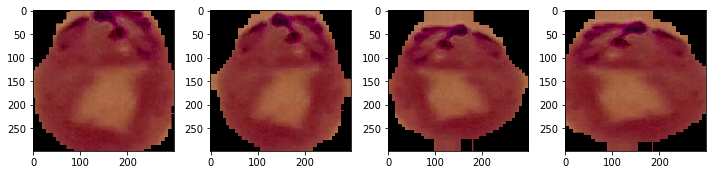

In [0]:
# Augmented versions of a particular sample
plot_augmented_images(train_gen,batch_index=2,sample_index=0)

In [0]:

xcept = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

model = Sequential()
model.add(xcept)
model.add(layers.Flatten())
model.add(layers.Dense(256, use_bias=False))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation = "softmax"))


In [0]:
# Unfreeze starting from the last convolution layer

xcept.Trainable=True

set_trainable=False
for layer in xcept.layers:
    if layer.name == 'block14_sepconv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 10, 10, 2048)      20861480  
_________________________________________________________________
flatten_2 (Flatten)          (None, 204800)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               52428800  
_________________________________________________________________
batch_normalization_10 (Batc (None, 256)               1024      
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                

In [0]:
# Compile the model
model.compile(optimizers.Adam(0.01), loss = "categorical_crossentropy", metrics=['accuracy'])

In [0]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

STEP_SIZE_TRAIN=train_gen.n//train_gen.batch_size
STEP_SIZE_TEST=valid_gen.n//valid_gen.batch_size

# If no improvement in validation loss, we stop the training
earlystopper = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# If no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.
reducel = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)

history = model.fit_generator(train_gen, steps_per_epoch=STEP_SIZE_TRAIN, 
                    validation_data=valid_gen,
                    validation_steps=STEP_SIZE_TEST,
                    epochs=10,
                   callbacks=[reducel, earlystopper])

In [0]:
#model.save_weights('finetuned_xceptv1_weights_for_predicting_malaria.h5')

We will look at what the finetuned Xceptionv1 model is learning in a separate notebook. 